In [3]:
import numpy as np
import sys
import os
sys.path.append(os.environ.get('OTF')+'/otf_engine')
import gp, env, struc, kernels, otf, md, md_run
sys.path.append(os.environ.get('OTF')+'/modules')
import qe_parsers, analyze_gp, eam, analyze_md, otf_parser, analyze_otf, otf_parser_v0, activation_parser, crystals
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy
import atomeye_helper
import matplotlib.image as mpimg

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

In [4]:
# set font size
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

# Cutoff test

In [5]:
two_file = \
    '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Sweep_Two_Body_Cutoff_3'
three_file = \
    '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Sweep_Three_Body_Cutoff_2'

two_noise = np.load(two_file+'/noise.npy')
two_err = np.load(two_file+'/test_errs.npy')
two_mse = np.load(two_file+'/mse.npy')
two_vars = np.load(two_file+'/vars.npy')
like = np.load(two_file+'/like.npy')

three_noise = np.load(three_file+'/noise.npy')
three_mse = np.load(three_file+'/mse.npy')
like_three = np.load(three_file+'/like.npy')
three_err = np.load(three_file+'/test_errs.npy')

cutoffs = np.arange(3.5, 8.1, 0.5)
three_cuts = np.arange(3.0, 4.6, 0.5)


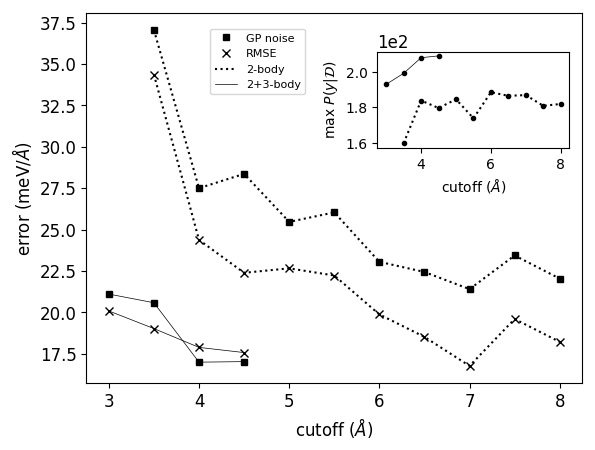

In [6]:
# error
fig, ax1 = plt.subplots()
ax1.set_xlabel('cutoff ($\AA$)')
ax1.set_ylabel('error (meV/$\AA$)')

ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'ks', label='GP noise', MarkerSize = 4)
ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'k:')
ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'kx', label='RMSE')
ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'k:', label='2-body')

ax1.plot(three_cuts, 1e3*three_noise, 'ks', MarkerSize = 4)
ax1.plot(three_cuts, 1e3*three_noise, 'k-', label='2+3-body', linewidth=0.5)
ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'kx')
ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'k-', linewidth=0.5)

# ax1.text(2.95, 22, '2+3-body')
# ax1.text(4.3, 29.5, '2-body')

# likelihood
ax3 = plt.axes([.58, .6, .3, .2])
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax3.text(6, 170, '2-body', fontsize=10)
# ax3.text(3.9, 195, '2+3-body', fontsize=10)


ax3.plot(cutoffs, like, 'k.')
ax3.plot(cutoffs, like, 'k:')
ax3.plot(three_cuts, like_three, 'k.')
ax3.plot(three_cuts, like_three, 'k-', linewidth=0.5)
ax3.set_xlabel('cutoff ($\AA$)', fontsize=10)
ax3.set_ylabel('max $P(y|\mathcal{D})$', fontsize=10)
ax3.tick_params(labelsize=10)

ax1.legend(loc=(0.25,0.78), fontsize=8)
# ax1.legend(loc='best', fontsize=8)
plt.show()

# Sweep training data

In [7]:
test_errs_td = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/test_errs.npy')
std_avgs_td = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/std_avgs.npy')
noise_td = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/noise.npy')
mse_td = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/mse.npy')

In [8]:
noise_td

array([-0.00058181, -0.01496673, -0.0360213 ,  0.00283139,  0.0248227 ,
        0.02240691,  0.01900561,  0.01938174,  0.01887351,  0.01885349,
        0.01736208,  0.0151086 ,  0.0139065 ,  0.01582771,  0.01529985,
        0.01347703,  0.01358661,  0.01359642,  0.01364985,  0.01574934,
        0.01523254,  0.01577199,  0.01629219,  0.01639894,  0.01633562,
        0.01640133,  0.01610269,  0.0164982 ,  0.01682068,  0.01698832,
        0.01689995,  0.01672827])

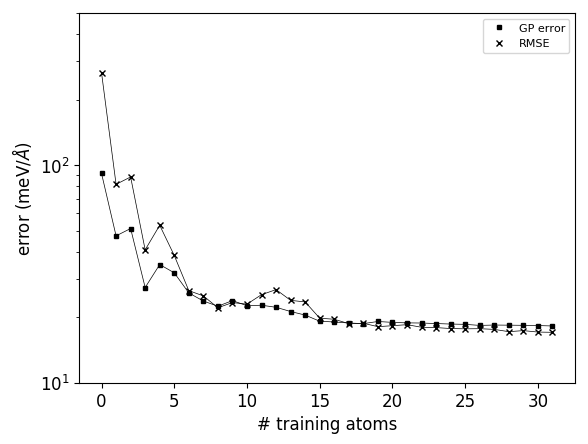

In [9]:
fig, ax = plt.subplots(1, 1)

ax.plot(1e3*np.sqrt(std_avgs_td**2+0.01672827**2), 'ks', label='GP error', markersize=3)
ax.plot(1e3*np.sqrt(std_avgs_td**2+0.01672827**2), 'k-', linewidth=0.5)
ax.plot(list(range(32)), 1e3*np.sqrt(mse_td), 'kx', label='RMSE', markersize=5)
ax.plot(list(range(32)), 1e3*np.sqrt(mse_td), 'k-', linewidth=0.5)
ax.set_ylabel('error (meV/$\AA$)')
ax.set_xlabel('# training atoms')
# plt.axhline(1e3*0.01672827, color='k',linestyle=':', label='GP noise')

# ax.text(10, 170, 'train', fontsize=10)
# ax.text(22, 170, 'test', fontsize=10)
# ax.text(3.9, 195, '2+3-body', fontsize=10)

ax.legend(loc='best', fontsize=8)
ax.set_yscale('log')
plt.ylim(10, 500)
plt.show()

# Sweep perturbation size

In [10]:
test_errs_pert = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/test_errs.npy')
mse_pert = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/mses.npy')
std_avgs_pert = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/std_avgs.npy')


In [11]:
pert_sizes = np.linspace(0.01, 0.09, 9)
pert_sizes

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

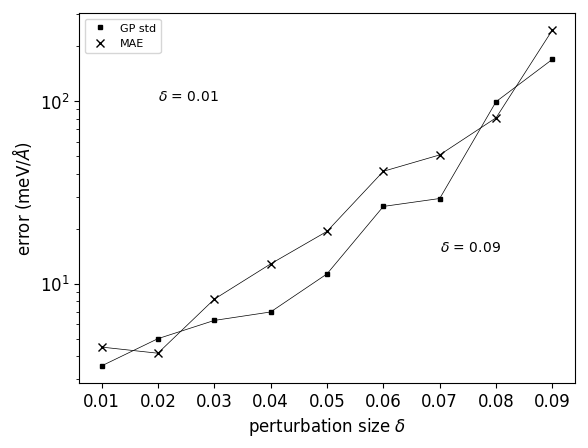

In [12]:
fig, ax = plt.subplots()
ax.plot(pert_sizes, std_avgs_pert*1e3, 'ks', label='GP std', markersize=3)
ax.plot(pert_sizes, std_avgs_pert*1e3, 'k-', linewidth=0.5)
ax.plot(pert_sizes, test_errs_pert*1e3, 'kx', label='MAE')
ax.plot(pert_sizes, test_errs_pert*1e3, 'k-', linewidth=0.5)
ax.text(0.02, 100, '$\delta$ = 0.01', fontsize=10)
ax.text(0.07, 15, '$\delta$ = 0.09', fontsize=10)
# ax.text(22, 170, 'test', fontsize=10)
ax.set_yscale('log')
ax.set_xlabel('perturbation size $\delta$')
ax.set_ylabel('error (meV/$\AA$)')
plt.legend(loc='best', fontsize=8)
plt.show()

# Put everything together in a single figure

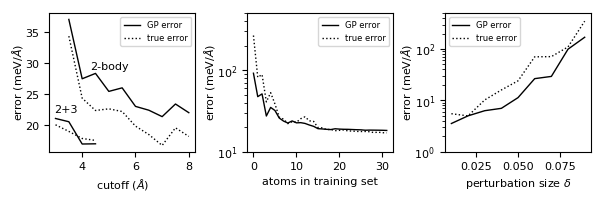

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fsize = 8
legsize = 6
# -------------------------------------
# part a: noise vs cutoff
# -------------------------------------

xlab1 = ax1.set_xlabel('cutoff ($\AA$)', fontsize=fsize)
# xlab1.set_position((0.5, 0.0001))
ax1.tick_params(labelsize=fsize)
ax1.set_ylabel('error (meV/$\AA$)', fontsize=fsize, labelpad=0)

# ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'ks', label='GP noise', MarkerSize = 3)
ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'k-', linewidth=1, label='GP error')
# ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'kx', label='RMSE')
ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'k:', linewidth=1, label='true error')

# ax1.plot(three_cuts, 1e3*three_noise, 'ks', MarkerSize = 3)
ax1.plot(three_cuts, 1e3*three_noise, 'k-', linewidth=1)
# ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'kx')
ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'k:', linewidth=1)

ax1.text(2.95, 22, '2+3', fontsize=fsize)
ax1.text(4.3, 29, '2-body', fontsize=fsize)

# likelihood
# ax4 = plt.axes([.58, .6, .3, .2])
# ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# ax4.plot(cutoffs, like, 'k.')
# ax4.plot(cutoffs, like, 'k:')
# ax4.plot(three_cuts, like_three, 'k.')
# ax4.plot(three_cuts, like_three, 'k-', linewidth=0.5)
# ax4.set_xlabel('cutoff ($\AA$)', fontsize=10)
# ax4.set_ylabel('max $P(y|\mathcal{D})$', fontsize=10)
# ax4.tick_params(labelsize=10)

ax1.legend(loc='best', fontsize=legsize)

# -------------------------------------
# part b: error vs # of training atoms
# -------------------------------------
# ax2.plot(1e3*np.sqrt(std_avgs_td**2+0.01672827**2), 'k.', label='GP error', markersize=2)
ax2.plot(1e3*np.sqrt(std_avgs_td**2+0.01672827**2), 'k-', linewidth=1, label='GP error')
# '$\sqrt{\sigma_n^2+\overline{\mathcal{V}}}$'
# ax2.plot(list(range(32)), 1e3*np.sqrt(mse_td), 'kv', label='RMSE', markersize=2)
ax2.plot(list(range(32)), 1e3*np.sqrt(mse_td), 'k:', linewidth=1, label='true error')
ax2.set_ylabel('error (meV/$\AA$)', fontsize=fsize, labelpad=0)
ax2.set_xlabel('atoms in training set', fontsize=fsize)
# plt.axhline(1e3*0.01672827, color='k',linestyle=':', label='GP noise')

# ax2.text(10, 170, 'train', fontsize=10)
# ax2.text(22, 170, 'test', fontsize=10)
# ax.text(3.9, 195, '2+3-body', fontsize=10)

ax2.legend(loc='best', fontsize=legsize)
ax2.set_yscale('log')
ax2.set_ylim(10, 500)

ax2.tick_params(labelsize=fsize)

# ------------------------------------
# part c: error vs perturbation size
# ------------------------------------
# ax3.plot(pert_sizes, std_avgs_pert*1e3, 'ks', label='GP std', markersize=3)
ax3.plot(pert_sizes, std_avgs_pert*1e3, 'k-', linewidth=1, label='GP error')
# ax3.plot(pert_sizes, test_errs_pert*1e3, 'kx', label='MAE')
ax3.plot(pert_sizes, np.sqrt(mse_pert)*1e3, 'k:', linewidth=1, label='true error')
# ax3.text(0.02, 100, '$\delta$ = 0.01', fontsize=10)
# ax3.text(0.07, 15, '$\delta$ = 0.09', fontsize=10)
# ax.text(22, 170, 'test', fontsize=10)
ax3.set_yscale('log')
ax3.set_xlabel('perturbation size $\delta$', fontsize=fsize)
ax3.set_ylabel('error (meV/$\AA$)', fontsize=fsize, labelpad=0)
ax3.legend(loc='best', fontsize=legsize)
ax3.tick_params(labelsize=fsize)
ax3.set_ylim(1, 500)

fig.set_size_inches(7, 1.8)
fig.subplots_adjust(wspace = 0.35)
fig.savefig('/Users/jonpvandermause/Research/GP/otf/paper/Main/calibrate.pdf', format='pdf',bbox_inches='tight')
plt.show()

# Visualize train / test structure

In [3]:
train_coord_file = '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Repeat_SCF/Repeat_SCF/positions_0.05_0.npy'
test_coord_file = '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Repeat_SCF/Repeat_SCF/positions_0.05_1.npy'

train_coord = np.load(train_coord_file)
test_coord = np.load(test_coord_file)


In [4]:
pos_list = [train_coord_file, test_coord_file]
cell = np.eye(3) * 8.092
folder_name = '/Users/jonpvandermause/test_train'
image_quality = 100
scr_dest = '/Users/jonpvandermause/scr_anim'
species = ['Al'] * 32

atomeye_helper.write_cfgs_from_pos(pos_list, cell, folder_name,
                                   image_quality, scr_dest, species)

In [21]:
train_file = '/Users/jonpvandermause/test_train/Pic/0.png'
# train_img = plt.imread(train_file, format='jpg')
train_img_2 = mpimg.imread(train_file)

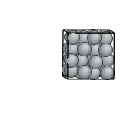

In [28]:
fig, ax = plt.subplots()
ax.imshow(train_img_2)
fig.set_size_inches((1, 1))
plt.axis('off')
plt.show()

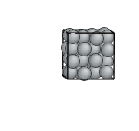

In [29]:

test_file = '/Users/jonpvandermause/test_train/Pic/1.png'
test_img = mpimg.imread(test_file)

fig, ax = plt.subplots()
ax.imshow(test_img)
fig.set_size_inches((1, 1))
plt.axis('off')
plt.show()


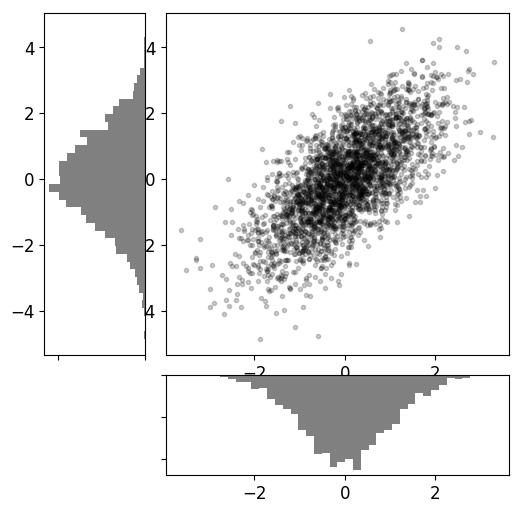

In [36]:
# Create some normally distributed data
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 3000).T

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

plt.show()